# Sentiment Analysis on different platforms

In [23]:
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
dataset = "youtube"
input_path = f"./{dataset}.csv"

In [ ]:
# Convert JSON to CSV if needed
def get_sentiment(stars):
    try:
        s = int(stars)
    except (TypeError, ValueError):
        return ''
    if s <= 2:
        return -1
    elif s == 3:
        return 0
    elif s >= 4:
        return 1
    return ''

def json_to_csv(json_path, csv_path):
    with open(json_path, 'r', encoding='utf-8') as infile:
        first_char = infile.read(1)
        infile.seek(0)
        if first_char == '[':
            try:
                entries = json.load(infile)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON list: {e}", file=sys.stderr)
                sys.exit(1)
            is_list = True
        else:
            entries = infile
            is_list = False

        with open(csv_path, 'w', newline='', encoding='utf-8') as outfile:
            writer = csv.writer(outfile)
            header = [
                'review_id', 'user_id', 'business_id',
                'stars', 'date', 'text',
                'useful', 'funny', 'cool',
                'Sentiment'
            ]
            writer.writerow(header)

            def write_row(entry):
                stars = entry.get('stars', '')
                sentiment = get_sentiment(stars)
                writer.writerow([
                    entry.get('review_id', ''),
                    entry.get('user_id', ''),
                    entry.get('business_id', ''),
                    stars,
                    entry.get('date', ''),
                    entry.get('text', '').replace('\n', ' ').strip(),
                    entry.get('useful', ''),
                    entry.get('funny', ''),
                    entry.get('cool', ''),
                    sentiment
                ])

            if is_list:
                for entry in entries:
                    write_row(entry)
            else:
                for line in entries:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        entry = json.loads(line)
                    except json.JSONDecodeError as e:
                        print(f"Skipping invalid JSON line: {e}", file=sys.stderr)
                        continue
                    write_row(entry)



In [ ]:
if dataset == 'yelp':
    json_to_csv(input_path, "yelp.csv")

## Feature Engineering and Model Selection

In [26]:
vectorizer = TfidfVectorizer(
        strip_accents='unicode', lowercase=True, stop_words='english', max_features=10000)

In [27]:
def tfidf(train, test):
    train = vectorizer.fit_transform(train)
    test = vectorizer.transform(test)

    return pd.DataFrame(train.toarray(), columns=vectorizer.get_feature_names_out()), pd.DataFrame(test.toarray(), columns=vectorizer.get_feature_names_out())

In [28]:
def load_data():
    data = pd.read_csv(input_path)
    data = data.dropna()

    if len(data) > 20000:
        print("Sampling 15000 rows from the dataset for faster processing...")
        data = data.sample(n=20000, random_state=42)

    # Rename 'Comment' column to 'text' for consistency
    data = data.rename(columns={'Comment': 'text'})
    
    return data

In [29]:
data = load_data()

In [30]:
data.head()

,text,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [31]:
def split_data(data):
    # select only 'text' and 'Sentiment' columns
    data = data[['text', 'Sentiment']].copy()

    train, test = train_test_split(data, train_size=0.8)

    sentiment_keys = {'positive', 'neutral', 'negative'}
    if set(train['Sentiment'].unique()).issubset(sentiment_keys) and set(test['Sentiment'].unique()).issubset(sentiment_keys):
        train['Sentiment'] = train['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
        test['Sentiment'] = test['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

    train = train.dropna(subset=['text', 'Sentiment'])
    test = test.dropna(subset=['text', 'Sentiment'])

    # Ensure 'text' column is of type string
    train['text'] = train['text'].astype(str)
    test['text'] = test['text'].astype(str)
    train = train[train['text'].str.strip() != ""]
    test = test[test['text'].str.strip() != ""]

    yTrain, yTest = train['Sentiment'], test['Sentiment']
    xTrain, xTest = tfidf(train['text'], test['text'])

    return xTrain, yTrain, xTest, yTest

In [32]:
def feature_selection(xTrain, xTest, yTrain):
    features = np.array(xTrain.columns)
    selector = SelectKBest(chi2, k=2000)

    xTrain = selector.fit_transform(xTrain, yTrain)
    xTest = selector.transform(xTest)

    selected_features = features[selector.get_support()]

    xTrain = pd.DataFrame(xTrain, columns=selected_features)
    xTest = pd.DataFrame(xTest, columns=selected_features)
    return xTrain, xTest

In [33]:
xTrain, yTrain, xTest, yTest = split_data(data)
print("Original Training Shape:", xTrain.shape)
xTrain, xTest = feature_selection(xTrain, xTest, yTrain)
print("Transformed Training Shape:", xTrain.shape)

Original Training Shape: (14691, 10000)
Transformed Training Shape: (14691, 2000)


In [51]:
def eval_randomsearch(clf, pgrid, xTrain, yTrain, xTest, yTest):
    """
    Given a sklearn classifier and a parameter grid to search,
    choose the optimal parameters from pgrid using Random Search CV
    and train the model using the training dataset and evaluate the
    performance on the test dataset. The random search cv should try
    at most 33% of the possible combinations.

    Parameters
    ----------
    clf : sklearn.ClassifierMixin
        The sklearn classifier model 
    pgrid : dict
        The dictionary of parameters to tune for in the model
    xTrain : nd-array with shape (n, d)
        Training data
    yTrain : 1d array with shape (n, )
        Array of labels associated with training data
    xTest : nd-array with shape (m, d)
        Test data
    yTest : 1d array with shape m
        Array of labels associated with test data.

    Returns
    -------
    resultDict: dict
        A Python dictionary with the following 4 keys,
        "AUC", "AUPRC", "F1", "Time" and the values are the floats
        associated with them for the test set.
    roc : dict
        A Python dictionary with 2 keys, fpr, and tpr, where
        each of the values are lists of the fpr and tpr associated
        with different thresholds. You should be able to use this
        to plot the ROC for the model performance on the test curve.
    bestParams: dict
        A Python dictionary with the best parameters chosen by your
        GridSearch. The values in the parameters should be something
        that was in the original pgrid.
    """
    permutations = np.prod([len(v) for v in pgrid.values()])
    start = time.time()

    cv = RandomizedSearchCV(clf, param_distributions=pgrid, n_iter=int(permutations*0.33), cv=10)
    cv.fit(xTrain, yTrain)

    timeElapsed = time.time() - start

    clf = cv.best_estimator_
    best_params = cv.best_params_

    yHat = clf.predict(xTest)
    yHat_proba = clf.predict_proba(xTest)

    auc = roc_auc_score(yTest, yHat_proba, multi_class='ovr')

    auprc = average_precision_score(yTest, yHat_proba)

    f1 = f1_score(yTest, yHat, average='weighted')

    # # training evaluation
    # yTrainHat = clf.predict(xTrain)
    # yTrainHat_proba = clf.predict_proba(xTrain)

    # train_auc = roc_auc_score(yTrain, yTrainHat_proba, multi_class='ovr')

    # train_auprc = average_precision_score(yTrain, yTrainHat_proba)

    # train_f1 = f1_score(yTrain, yTrainHat, average='weighted')

    # # plot
    # plt.figure()
    # plt.plot()

    return {'AUC': auc, 'AUPRC': auprc, 'F1': f1, 'Time': timeElapsed}, best_params


def eval_searchcv(clfName, clf, clfGrid,
                  xTrain, yTrain, xTest, yTest,
                  perfDict, bestParamDict):
    # evaluate random search and add to perfDict
    clfr_perf, rs_p  = eval_randomsearch(clf, clfGrid, xTrain,
                                            yTrain, xTest, yTest)
    perfDict[clfName + " (Random)"] = clfr_perf
    bestParamDict[clfName] = {"Random": rs_p}
    return perfDict, bestParamDict


def get_parameter_grid(mName):
    """
    Given a model name, return the parameter grid associated with it

    Parameters
    ----------
    mName : string
        name of the model (e.g., DT, KNN, LR (None))

    Returns
    -------
    pGrid: dict
        A Python dictionary with the appropriate parameters for the model.
        The dictionary should have at least 2 keys and each key should have
        at least 2 values to try.
    """
    if mName == 'DT':
        return {'max_depth': [10, 20, 30], 'min_samples_leaf': [10, 50, 100]}
    elif mName == 'LR (None)':
        return {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'tol': [0.0001, 0.0003, 0.0005]}
    elif mName == 'LR (L1)':
        return {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'tol': [0.0001, 0.0003, 0.0005]}
    elif mName == 'LR (L2)':
        return {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'tol': [0.0001, 0.0003, 0.0005]}
    elif mName == 'KNN':
        return {'n_neighbors': [10, 50, 100], 'p': [1, 2]}
    elif mName == 'NN':
        return {'alpha':[0.001, 0.01], 'hidden_layer_sizes': [(50,50),(100,50),(200,100)]}


def evaluate_models():
    perfDict = {}
    bestParamDict = {}

    print("Tuning Decision Tree --------")
    # Compare Decision Tree
    dtName = "DT"
    dtGrid = get_parameter_grid(dtName)
    # fill in
    dtClf = DecisionTreeClassifier()
    perfDict, bestParamDict = eval_searchcv(dtName, dtClf, dtGrid,
                                                   xTrain, yTrain, xTest, yTest,
                                                   perfDict, bestParamDict)
    print("Tuning Unregularized Logistic Regression --------")
    # logistic regression (unregularized)
    unregLrName = "LR (None)"
    unregLrGrid = get_parameter_grid(unregLrName)
    # fill in
    lrClf = LogisticRegression(max_iter=500)
    perfDict, bestParamDict = eval_searchcv(unregLrName, lrClf, unregLrGrid,
                                                   xTrain, yTrain, xTest, yTest,
                                                   perfDict, bestParamDict)
    # logistic regression (L1)
    print("Tuning Logistic Regression (Lasso) --------")
    lassoLrName = "LR (L1)"
    lassoLrGrid = get_parameter_grid(lassoLrName)
    # fill in
    lassoClf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500)
    perfDict, bestParamDict = eval_searchcv(lassoLrName, lassoClf, lassoLrGrid,
                                                   xTrain, yTrain, xTest, yTest,
                                                   perfDict, bestParamDict)
    # Logistic regression (L2)
    print("Tuning Logistic Regression (Ridge) --------")
    ridgeLrName = "LR (L2)"
    ridgeLrGrid = get_parameter_grid(ridgeLrName)
    # fill in
    ridgeClf = LogisticRegression(penalty='l2', max_iter=500)
    perfDict, bestParamDict = eval_searchcv(ridgeLrName, ridgeClf, ridgeLrGrid,
                                                   xTrain, yTrain, xTest, yTest,
                                                   perfDict, bestParamDict)
    # k-nearest neighbors
    print("Tuning K-nearest neighbors --------")
    knnName = "KNN"
    knnGrid = get_parameter_grid(knnName)
    # fill in
    knnClf = KNeighborsClassifier()
    perfDict, bestParamDict = eval_searchcv(knnName, knnClf, knnGrid,
                                                   xTrain, yTrain, xTest, yTest,
                                                   perfDict, bestParamDict)
    # neural networks
    print("Tuning neural networks --------")
    nnName = "NN"
    nnGrid = get_parameter_grid(nnName)
    # fill in
    nnClf = MLPClassifier(max_iter=200, early_stopping=True)
    perfDict, bestParamDict = eval_searchcv(nnName, nnClf, nnGrid,
                                                   xTrain, yTrain, xTest, yTest,
                                                   perfDict, bestParamDict)
    perfDF = pd.DataFrame.from_dict(perfDict, orient='index')
    print(perfDF)
    # store the best parameters
    with open('parameters', 'w') as f:
        json.dump(bestParamDict, f)

    return perfDict


In [52]:
perf_dict = evaluate_models()

Tuning Decision Tree --------
Tuning Unregularized Logistic Regression --------
Tuning Logistic Regression (Lasso) --------
Tuning Logistic Regression (Ridge) --------
Tuning K-nearest neighbors --------
Tuning neural networks --------
                         AUC     AUPRC        F1       Time
DT (Random)         0.762988  0.523667  0.642375  13.407271
LR (None) (Random)  0.871082  0.698040  0.734359  22.873616
LR (L1) (Random)    0.843477  0.648358  0.719604   5.828948
LR (L2) (Random)    0.864764  0.686310  0.730938  43.287226
KNN (Random)        0.740581  0.515227  0.607236  34.628957
NN (Random)         0.865409  0.687203  0.732686  15.001060


In [58]:
print(perf_dict)

{'DT (Random)': {'AUC': np.float64(0.7629883373397283), 'AUPRC': np.float64(0.5236671619810407), 'F1': 0.6423754135510539, 'Time': 13.407271385192871}, 'LR (None) (Random)': {'AUC': np.float64(0.8710815286106017), 'AUPRC': np.float64(0.6980400521164166), 'F1': 0.7343590621774216, 'Time': 22.873615741729736}, 'LR (L1) (Random)': {'AUC': np.float64(0.8434772684250288), 'AUPRC': np.float64(0.6483579514916871), 'F1': 0.7196044584920984, 'Time': 5.828948020935059}, 'LR (L2) (Random)': {'AUC': np.float64(0.8647637246030425), 'AUPRC': np.float64(0.6863097711331863), 'F1': 0.7309376671237117, 'Time': 43.28722620010376}, 'KNN (Random)': {'AUC': np.float64(0.7405811552281594), 'AUPRC': np.float64(0.5152274607697809), 'F1': 0.60723617672484, 'Time': 34.62895679473877}, 'NN (Random)': {'AUC': np.float64(0.8654087108450247), 'AUPRC': np.float64(0.6872031911498574), 'F1': 0.7326858371862858, 'Time': 15.001060009002686}}


In [59]:
selected_model = MLPClassifier(max_iter=200, early_stopping=True, hidden_layer_sizes=(50, 50), alpha=0.01) # youtube
# selected_model = MLPClassifier(max_iter=200, early_stopping=True, hidden_layer_sizes=(50, 50), alpha=0.001) # yelp

## Identify Common Misclassified Patterns

In [37]:
selected_model.fit(xTrain, yTrain)

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(50, 50))

In [38]:
def get_misclassified_samples(model, xTest, yTest):
    yPred = model.predict(xTest)
    misclassified_indices = np.where(yPred != yTest)[0]
    
    misclassified_samples = xTest.iloc[misclassified_indices].copy()
    misclassified_samples['True Label'] = yTest.iloc[misclassified_indices].values
    misclassified_samples['Predicted Label'] = yPred[misclassified_indices]
    
    return misclassified_samples

In [39]:
misclassified = get_misclassified_samples(selected_model, xTest, yTest)
misclassified_df = pd.DataFrame(misclassified)

In [40]:
# convert misclassified features from vectorized form to original text
def vector_to_text(vectorized_comments, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    comments = []
    for index, row in vectorized_comments.iterrows():
        comment = " ".join([feature_names[i] for i in range(len(row)) if row[i] > 0])
        comments.append(comment)
    return comments

In [41]:
def get_most_common_words(df, n=100):
    all_comments = ' '.join(df['text'])
    words = all_comments.split()
    word_counts = pd.Series(words).value_counts()
    return word_counts.head(n)

In [42]:
misclassified_comments = vector_to_text(misclassified_df.drop(columns=['True Label', 'Predicted Label']), vectorizer)
misclassified_df['text'] = misclassified_comments
most_common_words = get_most_common_words(misclassified_df)

In [43]:
# Save most common words to a CSV file
most_common_words_df = pd.DataFrame(most_common_words).reset_index()
most_common_words_df.columns = ['Word', 'Count']
most_common_words_df.to_csv(f'most_misclassified_{dataset}.csv', index=False)

## Plot ROC Curve

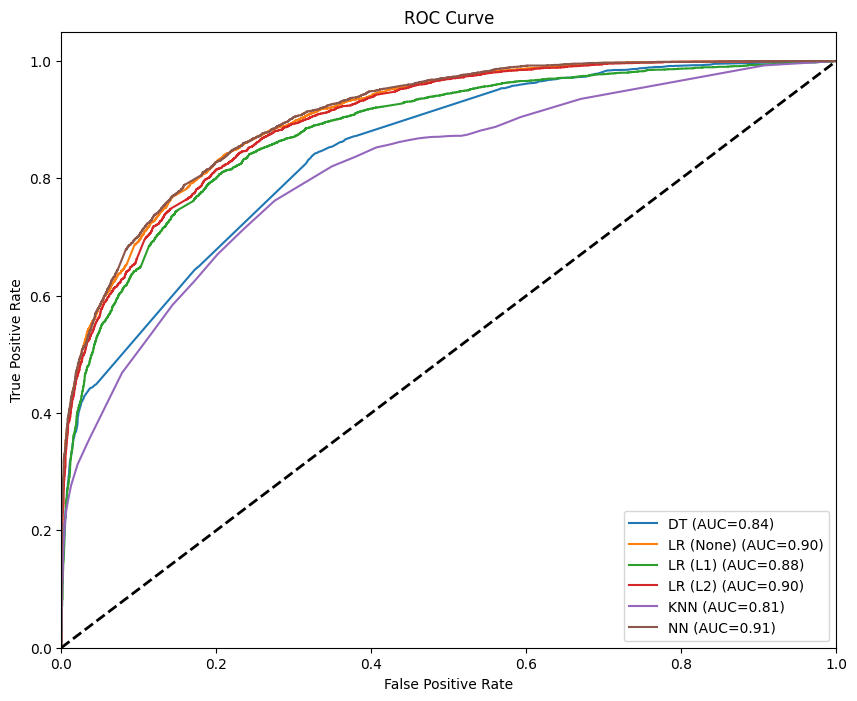

In [63]:
import json
from sklearn.metrics import roc_curve, auc

# Load best parameters
with open('parameters', 'r') as f:
    best_params = json.load(f)

# Define model constructors
model_defs = {
    'DT': lambda params: DecisionTreeClassifier(**params),
    'LR (None)': lambda params: LogisticRegression(max_iter=500, **params),
    'LR (L1)': lambda params: LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, **params),
    'LR (L2)': lambda params: LogisticRegression(penalty='l2', max_iter=500, **params),
    'KNN': lambda params: KNeighborsClassifier(**params),
    'NN': lambda params: MLPClassifier(max_iter=200, early_stopping=True, **params)
}

plt.figure(figsize=(10, 8))
for model_name, constructor in model_defs.items():
    params = best_params.get(model_name, {}).get('Random', {})
    if not params:
        continue
    model = constructor(params)
    model.fit(xTrain, yTrain)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(xTest)
    else:
        y_score = model.decision_function(xTest)

    # Binarize the output for multiclass ROC
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(yTest, classes=sorted(np.unique(yTest)))

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()